# Atmo Model Training Notebook

Train an Atmo Model using `usl_models` lib.

In [28]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import keras
import os, time
import pathlib
from usl_models.atmo_ml.model import AtmoModel, AtmoModelParams
from usl_models.atmo_ml import dataset, visualizer, vars
from google.cloud import storage

import logging

logging.getLogger().setLevel(logging.INFO)

# climateiq-study-area-feature-chunks/NYC_Heat/NYC_summer_2000_01p
# Define bucket names and folder paths
data_bucket_name = "climateiq-study-area-feature-chunks"
label_bucket_name = "climateiq-study-area-label-chunks"
time_steps_per_day = 6
batch_size = 2

sim_dirs = [
    (
        "NYC_Heat_Test",
        [
            "NYC_summer_2000_01p",
            # 'NYC_summer_2010_99p',
            # 'NYC_summer_2015_50p',
            # 'NYC_summer_2017_25p',
            # 'NYC_summer_2018_75p'
        ],
    ),
    (
        "PHX_Heat_Test",
        [
            # 'PHX_summer_2008_25p',
            # 'PHX_summer_2009_50p',
            # 'PHX_summer_2011_99p',
            # 'PHX_summer_2015_75p',
            # 'PHX_summer_2020_01p'
        ],
    ),
]

sim_names = []
for sim_dir, subdirs in sim_dirs:
    for subdir in subdirs:
        sim_names.append(sim_dir + "/" + subdir)

print(sim_names)

client = storage.Client(project="climateiq")
feature_bucket = client.bucket(data_bucket_name)
label_bucket = client.bucket(label_bucket_name)

output_vars = [
    vars.SpatiotemporalOutput.RH2
]

train_frac = 0.8

sim_name = "NYC_Heat_Test/NYC_summer_2000_01p"
date = "2000-05-25"
filecache_path = pathlib.Path("data/filecache")

example_keys=[
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-26"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-27"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-28")
]

# Create training dataset with fused spatiotemporal data
train_ds = dataset.load_dataset_cached(
    filecache_path,
    output_vars=output_vars,
    example_keys=example_keys
).batch(batch_size=batch_size)
val_ds = dataset.load_dataset_cached(
    filecache_path,
    output_vars=output_vars,
    example_keys=example_keys
).batch(batch_size=batch_size)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['NYC_Heat_Test/NYC_summer_2000_01p']


In [29]:
# Initialize the Atmo Model
model_params = AtmoModelParams(output_vars=output_vars)
model = AtmoModel(model_params)
model.summary(expand_nested=True)

Model: "atmo_conv_lstm_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  488       
                                                                 
 spatial_cnn (Sequential)    (None, 200, 200, 30)      0         
                                                                 
 spatiotemporal_cnn (Sequen  (None, None, 200, 200,    0         
 tial)                       12)                                 
                                                                 
 conv_lstm (Sequential)      (None, 200, 200, 512)     28366848  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv_lstm2d_2 (ConvLSTM2D  (None, 200, 200, 512)     28366848 |
| )                                                             |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 rh2_output_cnn (Sequential  (None, 200, 200, 1)  

In [30]:
# Train the model
# Create a unique log directory by appending the current timestamp
log_dir = os.path.join("./logs", "run_" + time.strftime("%Y%m%d-%H%M%S"))
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(train_ds, val_ds, epochs=50, callbacks=[tb_callback], validation_freq=10)

./logs/run_20250129-004518
Epoch 1/50


2025-01-29 00:45:21.581409: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inatmo_conv_lstm_2/conv_lstm/conv_lstm2d_2/while/body/_1/atmo_conv_lstm_2/conv_lstm/conv_lstm2d_2/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


      1/Unknown - 30s 30s/step - loss: 0.2050 - mean_absolute_error: 0.4283 - root_mean_squared_error: 0.4528

INFO:root:Total generated samples: 4


2/2 [==============================] - 31s 1s/step - loss: 0.1534 - mean_absolute_error: 0.3519 - root_mean_squared_error: 0.3917
Epoch 2/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0387 - mean_absolute_error: 0.1734 - root_mean_squared_error: 0.1967

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0591 - mean_absolute_error: 0.2120 - root_mean_squared_error: 0.2431
Epoch 3/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0188 - mean_absolute_error: 0.1141 - root_mean_squared_error: 0.1371

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0380 - mean_absolute_error: 0.1644 - root_mean_squared_error: 0.1950
Epoch 4/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0719 - root_mean_squared_error: 0.0910

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0100 - mean_absolute_error: 0.0768 - root_mean_squared_error: 0.1000
Epoch 5/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0442 - mean_absolute_error: 0.1923 - root_mean_squared_error: 0.2103

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0285 - mean_absolute_error: 0.1401 - root_mean_squared_error: 0.1688
Epoch 6/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0140 - mean_absolute_error: 0.0996 - root_mean_squared_error: 0.1184

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0153 - mean_absolute_error: 0.1028 - root_mean_squared_error: 0.1238
Epoch 7/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0056 - mean_absolute_error: 0.0541 - root_mean_squared_error: 0.0748

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0173 - mean_absolute_error: 0.1003 - root_mean_squared_error: 0.1317
Epoch 8/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0607 - root_mean_squared_error: 0.0828

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0135 - mean_absolute_error: 0.0890 - root_mean_squared_error: 0.1162
Epoch 9/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0048 - mean_absolute_error: 0.0513 - root_mean_squared_error: 0.0694

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0636 - root_mean_squared_error: 0.0848
Epoch 10/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0107 - mean_absolute_error: 0.0913 - root_mean_squared_error: 0.1032

INFO:root:Total generated samples: 4


2/2 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0870 - root_mean_squared_error: 0.1041

INFO:root:Total generated samples: 4


2/2 [==============================] - 11s 8s/step - loss: 0.0108 - mean_absolute_error: 0.0870 - root_mean_squared_error: 0.1041 - val_loss: 0.0108 - val_mean_absolute_error: 0.0880 - val_root_mean_squared_error: 0.1040
Epoch 11/50


2025-01-29 00:46:44.524608: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12605888808023624007
2025-01-29 00:46:44.524670: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8883337368882736267
2025-01-29 00:46:44.524682: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1364155305828515924
2025-01-29 00:46:44.524688: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4405708192660974132
2025-01-29 00:46:44.524704: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11029955692777852456


1/2 [==============>...............] - ETA: 3s - loss: 0.0113 - mean_absolute_error: 0.0950 - root_mean_squared_error: 0.1064

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0102 - mean_absolute_error: 0.0842 - root_mean_squared_error: 0.1009
Epoch 12/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0047 - mean_absolute_error: 0.0527 - root_mean_squared_error: 0.0685

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0650 - root_mean_squared_error: 0.0857
Epoch 13/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0044 - mean_absolute_error: 0.0467 - root_mean_squared_error: 0.0663

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0084 - mean_absolute_error: 0.0675 - root_mean_squared_error: 0.0918
Epoch 14/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0046 - mean_absolute_error: 0.0498 - root_mean_squared_error: 0.0682

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0624 - root_mean_squared_error: 0.0845
Epoch 15/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0037 - mean_absolute_error: 0.0432 - root_mean_squared_error: 0.0611

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0558 - root_mean_squared_error: 0.0772
Epoch 16/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0050 - mean_absolute_error: 0.0540 - root_mean_squared_error: 0.0709

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0645 - root_mean_squared_error: 0.0846
Epoch 17/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0045 - mean_absolute_error: 0.0502 - root_mean_squared_error: 0.0670

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0587 - root_mean_squared_error: 0.0787
Epoch 18/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0036 - mean_absolute_error: 0.0420 - root_mean_squared_error: 0.0599

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0548 - root_mean_squared_error: 0.0767
Epoch 19/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0043 - mean_absolute_error: 0.0474 - root_mean_squared_error: 0.0655

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0581 - root_mean_squared_error: 0.0797
Epoch 20/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0038 - mean_absolute_error: 0.0433 - root_mean_squared_error: 0.0618

INFO:root:Total generated samples: 4


2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0545 - root_mean_squared_error: 0.0755

INFO:root:Total generated samples: 4


2/2 [==============================] - 10s 7s/step - loss: 0.0057 - mean_absolute_error: 0.0545 - root_mean_squared_error: 0.0755 - val_loss: 0.0052 - val_mean_absolute_error: 0.0521 - val_root_mean_squared_error: 0.0725
Epoch 21/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0034 - mean_absolute_error: 0.0415 - root_mean_squared_error: 0.0582

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0558 - root_mean_squared_error: 0.0757
Epoch 22/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0036 - mean_absolute_error: 0.0441 - root_mean_squared_error: 0.0596

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0565 - root_mean_squared_error: 0.0756
Epoch 23/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0032 - mean_absolute_error: 0.0399 - root_mean_squared_error: 0.0567

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0525 - root_mean_squared_error: 0.0729
Epoch 24/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0035 - mean_absolute_error: 0.0415 - root_mean_squared_error: 0.0589

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0534 - root_mean_squared_error: 0.0743
Epoch 25/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0034 - mean_absolute_error: 0.0416 - root_mean_squared_error: 0.0586

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0527 - root_mean_squared_error: 0.0731
Epoch 26/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0031 - mean_absolute_error: 0.0395 - root_mean_squared_error: 0.0558

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0524 - root_mean_squared_error: 0.0722
Epoch 27/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0032 - mean_absolute_error: 0.0409 - root_mean_squared_error: 0.0567

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0528 - root_mean_squared_error: 0.0722
Epoch 28/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0031 - mean_absolute_error: 0.0400 - root_mean_squared_error: 0.0559

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0514 - root_mean_squared_error: 0.0710
Epoch 29/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0031 - mean_absolute_error: 0.0399 - root_mean_squared_error: 0.0560

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0513 - root_mean_squared_error: 0.0711
Epoch 30/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0031 - mean_absolute_error: 0.0397 - root_mean_squared_error: 0.0558

INFO:root:Total generated samples: 4


2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0511 - root_mean_squared_error: 0.0707

INFO:root:Total generated samples: 4


2/2 [==============================] - 10s 7s/step - loss: 0.0050 - mean_absolute_error: 0.0511 - root_mean_squared_error: 0.0707 - val_loss: 0.0046 - val_mean_absolute_error: 0.0478 - val_root_mean_squared_error: 0.0675
Epoch 31/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0030 - mean_absolute_error: 0.0389 - root_mean_squared_error: 0.0547

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0508 - root_mean_squared_error: 0.0700
Epoch 32/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0030 - mean_absolute_error: 0.0400 - root_mean_squared_error: 0.0551

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0514 - root_mean_squared_error: 0.0702
Epoch 33/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0029 - mean_absolute_error: 0.0387 - root_mean_squared_error: 0.0538

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0503 - root_mean_squared_error: 0.0694
Epoch 34/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0029 - mean_absolute_error: 0.0382 - root_mean_squared_error: 0.0534

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0501 - root_mean_squared_error: 0.0692
Epoch 35/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0029 - mean_absolute_error: 0.0385 - root_mean_squared_error: 0.0538

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0499 - root_mean_squared_error: 0.0689
Epoch 36/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0028 - mean_absolute_error: 0.0381 - root_mean_squared_error: 0.0530

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0497 - root_mean_squared_error: 0.0683
Epoch 37/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0028 - mean_absolute_error: 0.0385 - root_mean_squared_error: 0.0532

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0499 - root_mean_squared_error: 0.0684
Epoch 38/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0028 - mean_absolute_error: 0.0381 - root_mean_squared_error: 0.0528

INFO:root:Total generated samples: 4


2/2 [==============================] - 6s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0491 - root_mean_squared_error: 0.0676
Epoch 39/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0028 - mean_absolute_error: 0.0382 - root_mean_squared_error: 0.0532

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0491 - root_mean_squared_error: 0.0675
Epoch 40/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0028 - mean_absolute_error: 0.0381 - root_mean_squared_error: 0.0527

INFO:root:Total generated samples: 4


2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0488 - root_mean_squared_error: 0.0670

INFO:root:Total generated samples: 4


2/2 [==============================] - 10s 7s/step - loss: 0.0045 - mean_absolute_error: 0.0488 - root_mean_squared_error: 0.0670 - val_loss: 0.0041 - val_mean_absolute_error: 0.0459 - val_root_mean_squared_error: 0.0642
Epoch 41/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0027 - mean_absolute_error: 0.0379 - root_mean_squared_error: 0.0524

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0490 - root_mean_squared_error: 0.0672
Epoch 42/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0027 - mean_absolute_error: 0.0378 - root_mean_squared_error: 0.0521

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0487 - root_mean_squared_error: 0.0667
Epoch 43/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0027 - mean_absolute_error: 0.0373 - root_mean_squared_error: 0.0517

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0482 - root_mean_squared_error: 0.0661
Epoch 44/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0027 - mean_absolute_error: 0.0375 - root_mean_squared_error: 0.0518

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0484 - root_mean_squared_error: 0.0661
Epoch 45/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0026 - mean_absolute_error: 0.0372 - root_mean_squared_error: 0.0513

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0481 - root_mean_squared_error: 0.0658
Epoch 46/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0026 - mean_absolute_error: 0.0373 - root_mean_squared_error: 0.0512

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0481 - root_mean_squared_error: 0.0656
Epoch 47/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0026 - mean_absolute_error: 0.0374 - root_mean_squared_error: 0.0514

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0479 - root_mean_squared_error: 0.0654
Epoch 48/50
1/2 [==============>...............] - ETA: 2s - loss: 0.0026 - mean_absolute_error: 0.0371 - root_mean_squared_error: 0.0507

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0042 - mean_absolute_error: 0.0477 - root_mean_squared_error: 0.0650
Epoch 49/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0026 - mean_absolute_error: 0.0371 - root_mean_squared_error: 0.0507

INFO:root:Total generated samples: 4


2/2 [==============================] - 5s 2s/step - loss: 0.0042 - mean_absolute_error: 0.0475 - root_mean_squared_error: 0.0646
Epoch 50/50
1/2 [==============>...............] - ETA: 3s - loss: 0.0025 - mean_absolute_error: 0.0369 - root_mean_squared_error: 0.0503

INFO:root:Total generated samples: 4


2/2 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0474 - root_mean_squared_error: 0.0644

INFO:root:Total generated samples: 4


2/2 [==============================] - 10s 7s/step - loss: 0.0042 - mean_absolute_error: 0.0474 - root_mean_squared_error: 0.0644 - val_loss: 0.0037 - val_mean_absolute_error: 0.0441 - val_root_mean_squared_error: 0.0612


INFO:root:Total generated samples: 4


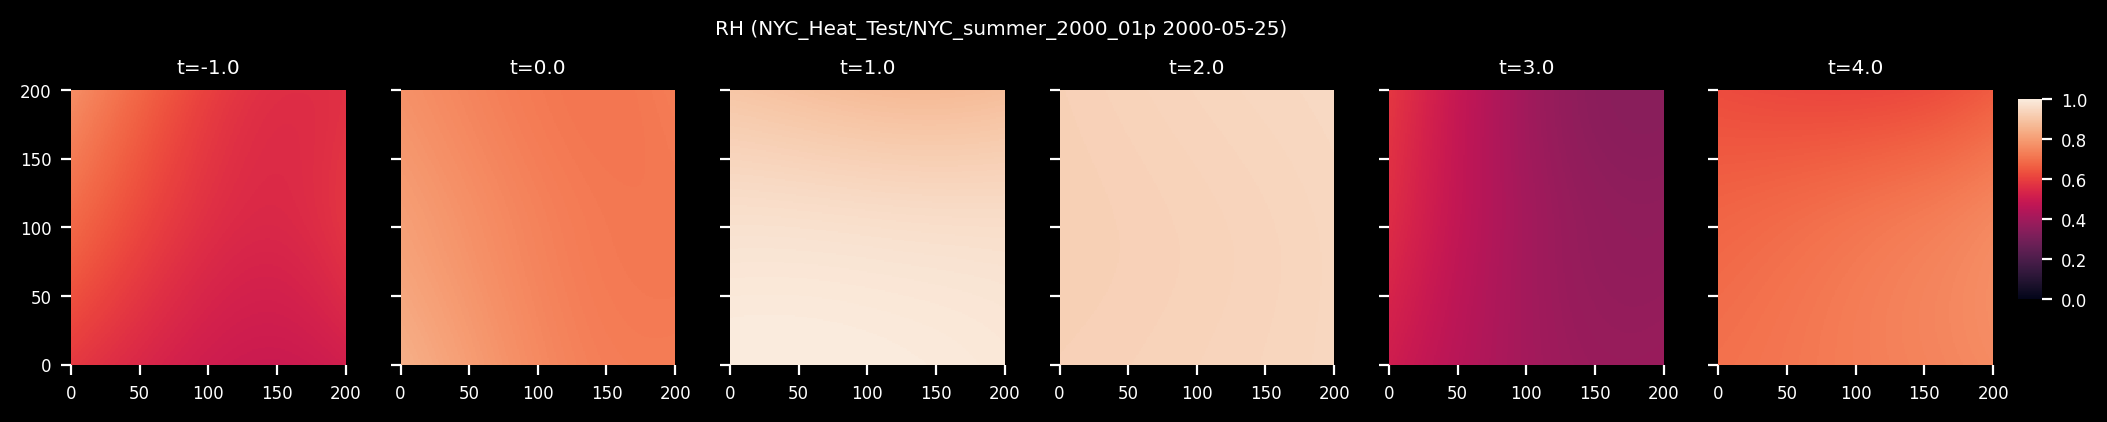

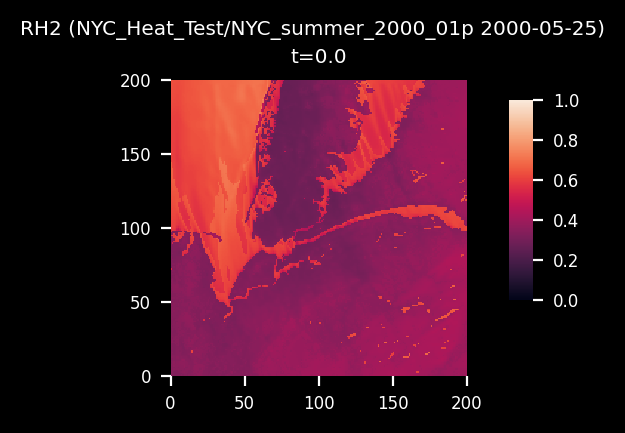

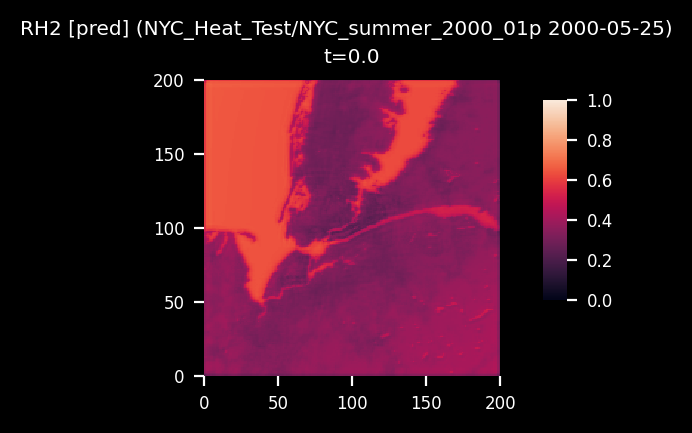

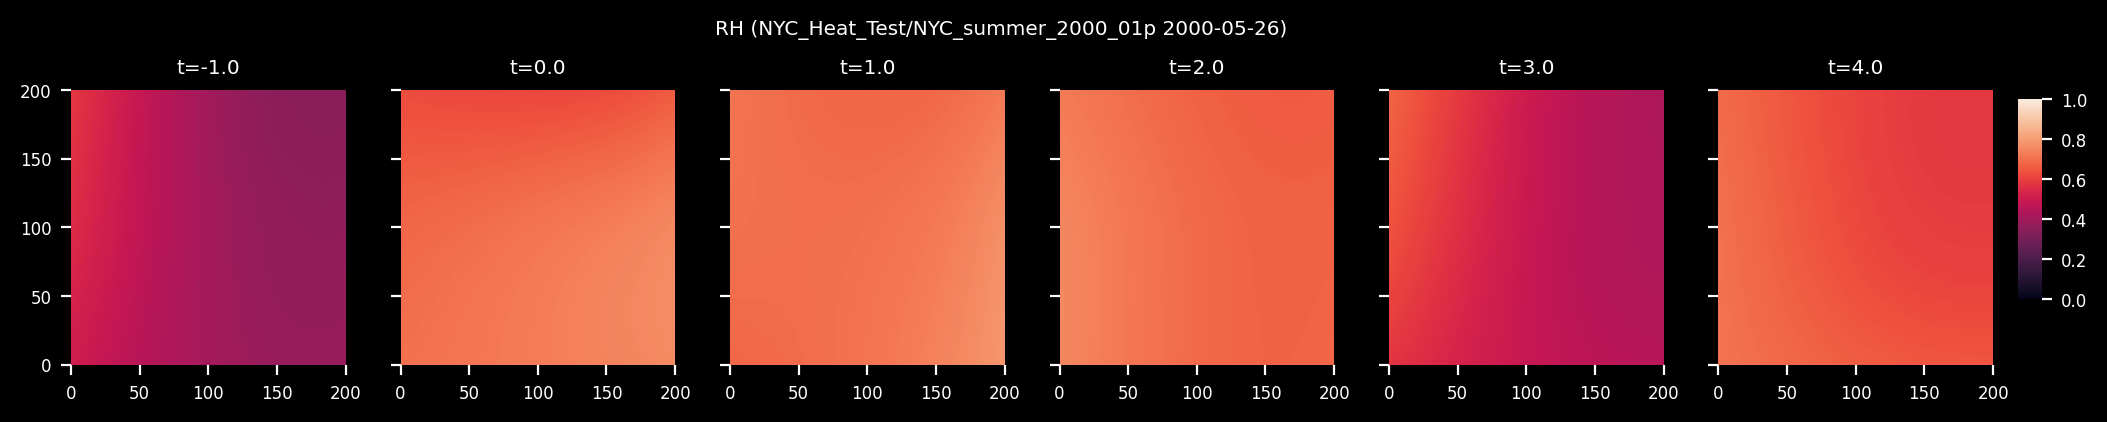

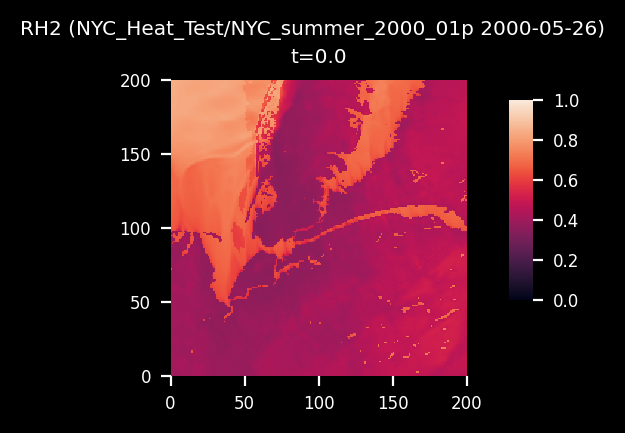

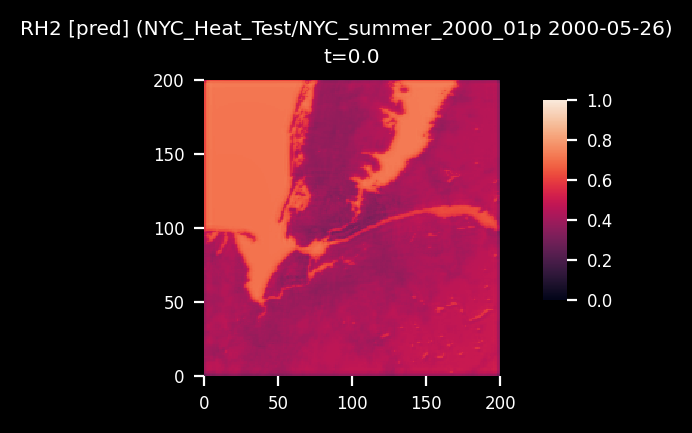

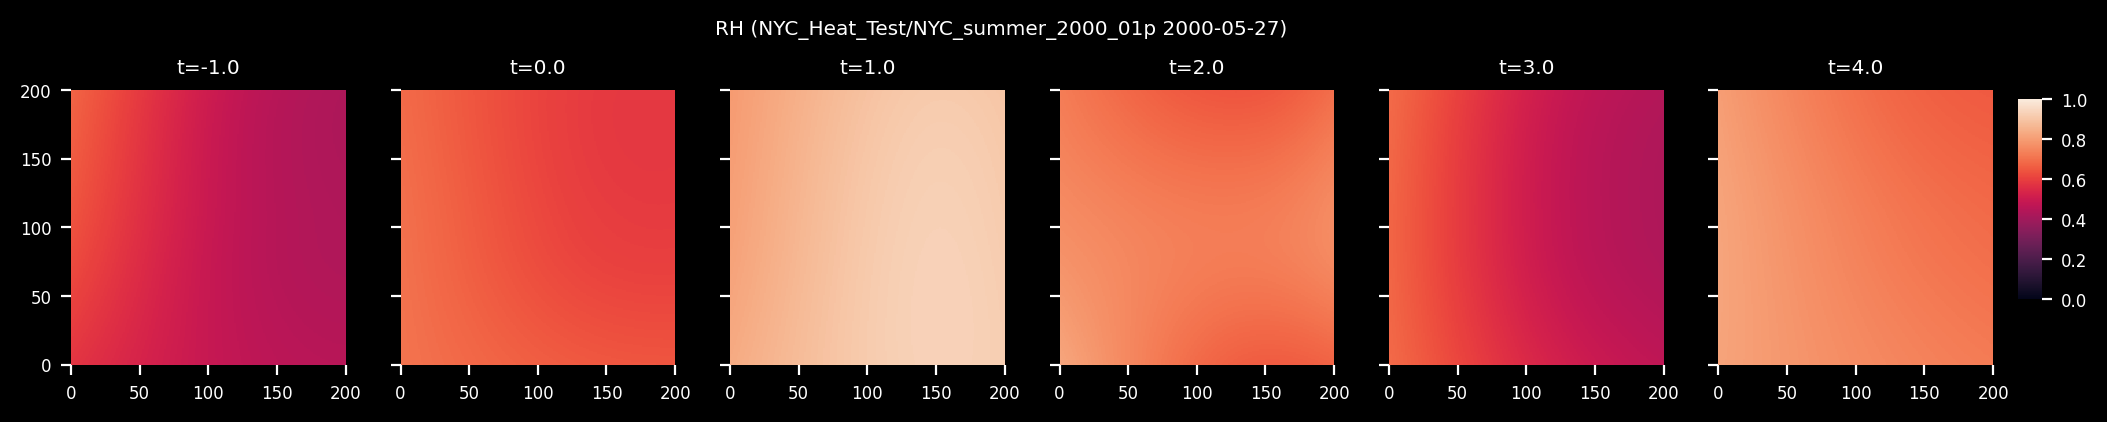

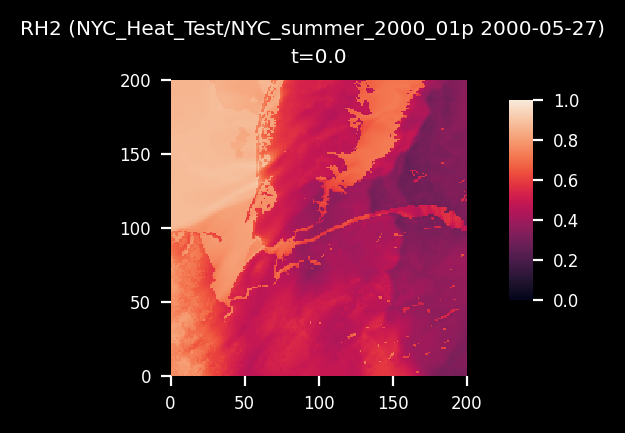

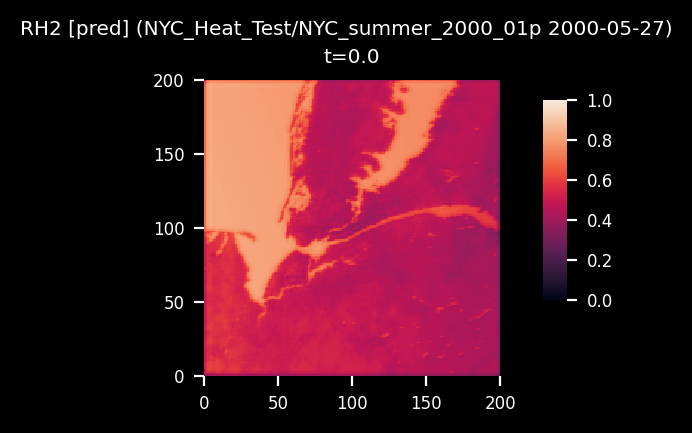

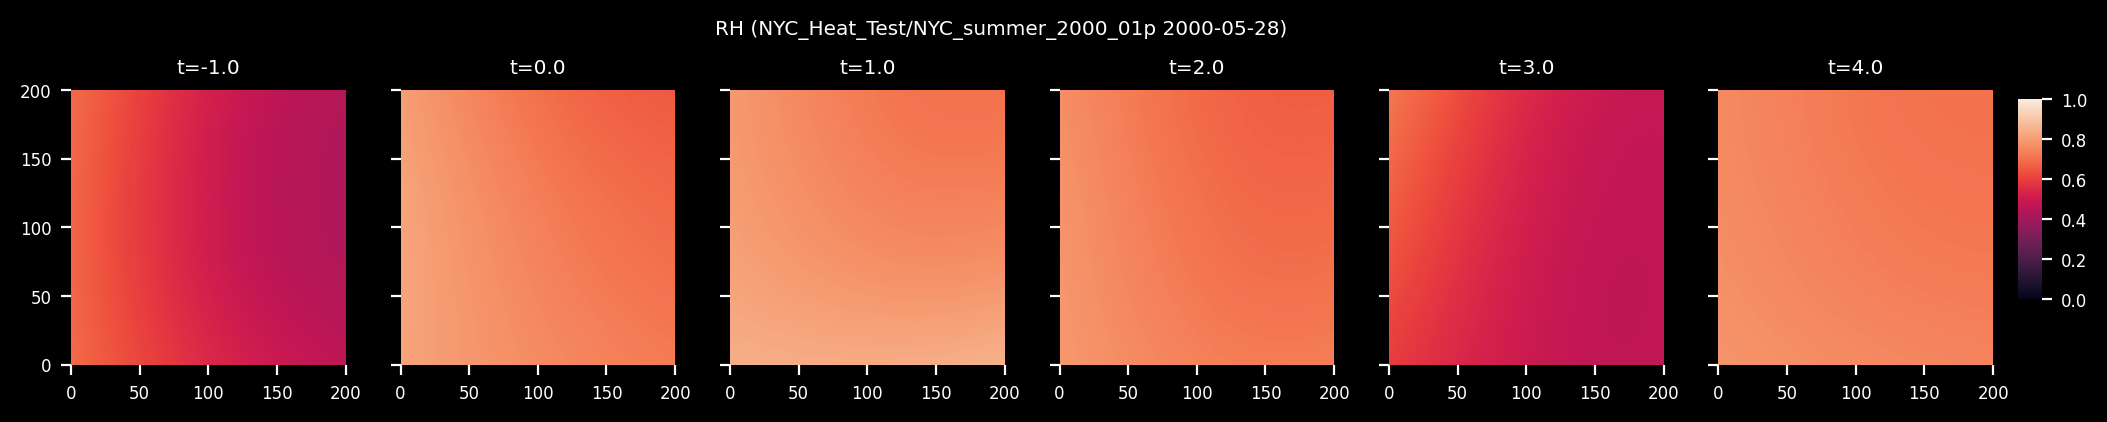

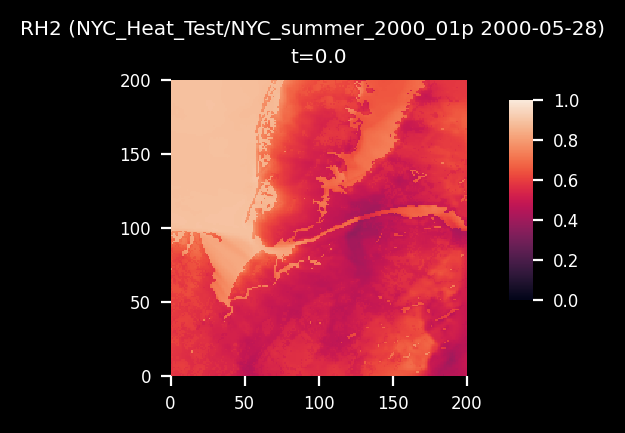

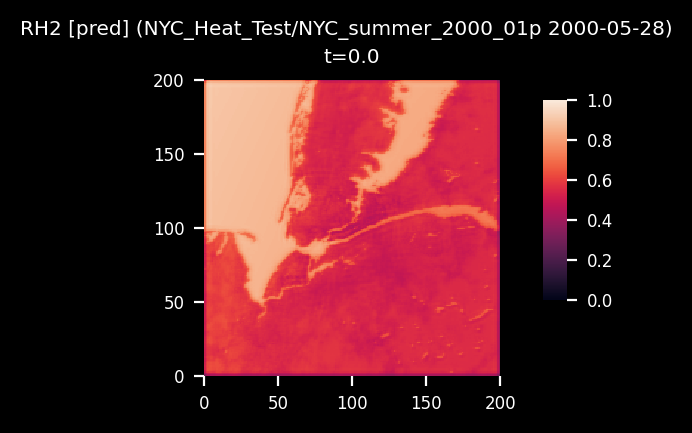

In [31]:
visualizer.init_plt()

for input_batch, label_batch in val_ds:
    preds = model.call(input_batch)
    for b, _ in enumerate(label_batch):
        figs = visualizer.plot(
            inputs={k: v[b] for k, v in input_batch.items()},
            label=tf.expand_dims(label_batch[b], axis=0),
            pred=tf.expand_dims(preds[b], axis=0),
            st_var=vars.Spatiotemporal.RH,
            sto_var=vars.SpatiotemporalOutput.RH2,
        )
        for fig in figs:
            fig.show()